# Explicabilidad de un Modelo de Detección de Fraude con LightGBM y SHAP

## Introducción

La detección de fraudes es una tarea crítica en diversas aplicaciones financieras y de seguridad. Desarrollar modelos de machine learning efectivos es esencial, pero comprender cómo toman decisiones estos modelos es igualmente importante. En este notebook, exploraremos la explicabilidad de un modelo de detección de fraude construido con LightGBM, una biblioteca eficiente para gradient boosting.

### Herramientas de Explicabilidad Utilizadas

1. **Árbol de decisión:**
   - Para comprender cómo toma decisiones individuales nuestro modelo, visualizaremos un árbol de decisión representativo.



3. **Gráfico de Importancia de Variables:**
   - Analizaremos las diez variables más importantes según LightGBM para entender qué características influyen más en las predicciones del modelo.



4. **Histograma de Split Value:**
   - Exploraremos la distribución de los valores de split en el árbol de decisión, proporcionando información valiosa sobre cómo el modelo divide las variables para tomar decisiones.



5. **SHAP (SHapley Additive exPlanations):**
   - Utilizaremos SHAP para obtener una comprensión más profunda de las contribuciones individuales de las variables a cada predicción del modelo.
   - Visualizaremos un gráfico de Tree explainer para un caso específico.
   - Crearemos un summary plot para entender la importancia relativa de cada característica en todo el conjunto de datos.



6. **Perfiles de Instancias con K-Means:**
   - Aplicaremos K-Means para agrupar instancias similares de fraude en el conjunto de datos de prueba, creando perfiles de comportamiento fraudulento.


A través de estas técnicas, buscamos proporcionar una visión más completa y transparente de nuestro modelo de detección de fraude, permitiendo una toma de decisiones más informada y confiable en aplicaciones críticas.

Importamos las librerías necesarias para este cuaderno:

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import itertools
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler
import joblib as joblib
import shap as shap
from numpy import unique
from numpy import where
from matplotlib import pyplot
import lightgbm as lgbm
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

Leemos el csv correspondiente:

In [2]:
test_data = pd.read_csv('../data/test_data.csv')

X_test_red = test_data.drop('fraud_bool', axis=1)
y_test_red = test_data['fraud_bool']

Importamos el modelo:

In [3]:
model_filename = 'saved_model.joblib'
modelo = joblib.load(model_filename)

### Explicabilidad del Modelo

### Árbol de decisión

Contruimos un árbol de decisión interactivo donde se podrá obtener la visualización del árbol que escoja. Dentro de las opciones interactivas también se escoge la información que se desee ver en el gráfico y el nivel de precisión (lugares decimales) del umbral establecido en cada variable y el valor que escojamos visualizar. Para motivos de este notebook, estaremos interpretando el split_gain de árbol 1.

In [4]:
def render_tree(tree_index, show_info, precision=3):
    show_info = None if 'None' in show_info else show_info
    return lgbm.create_tree_digraph(modelo, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

In [5]:
from ipywidgets import interact, SelectMultiple
INTERACTIVE = True

In [46]:
if INTERACTIVE:
    
    tree_index = 20
    interact(render_tree,
             tree_index=tree_index,
             show_info=SelectMultiple( 
                 options=['None',
                          'split_gain',
                          'internal_value',
                          'internal_count',
                          'internal_weight',
                          'leaf_count',
                          'leaf_weight',
                          'data_percentage'],
                 value=['None']),
             precision=(0, 10))
    tree = None
else:
    tree = render_tree(53, ['None'])
tree

interactive(children=(IntSlider(value=20, description='tree_index', max=60, min=-20), SelectMultiple(descripti…

Según observamos el el gráfico del árbol perteneciente al proceso de clasificación para la instancia 0 las variables housing_status, device_os y has_other_cards proveen el mayor split gain indicando que estas divisiones tienen una alta efectividad y llevan a una mejor predicción. 

Para motivos de visibilidad en la versión HTML de este notebook, insertamos una copia del árbol 1. Para poder interactuar y crear otros árboles se debe utilizar la versión .ipynb del notebook

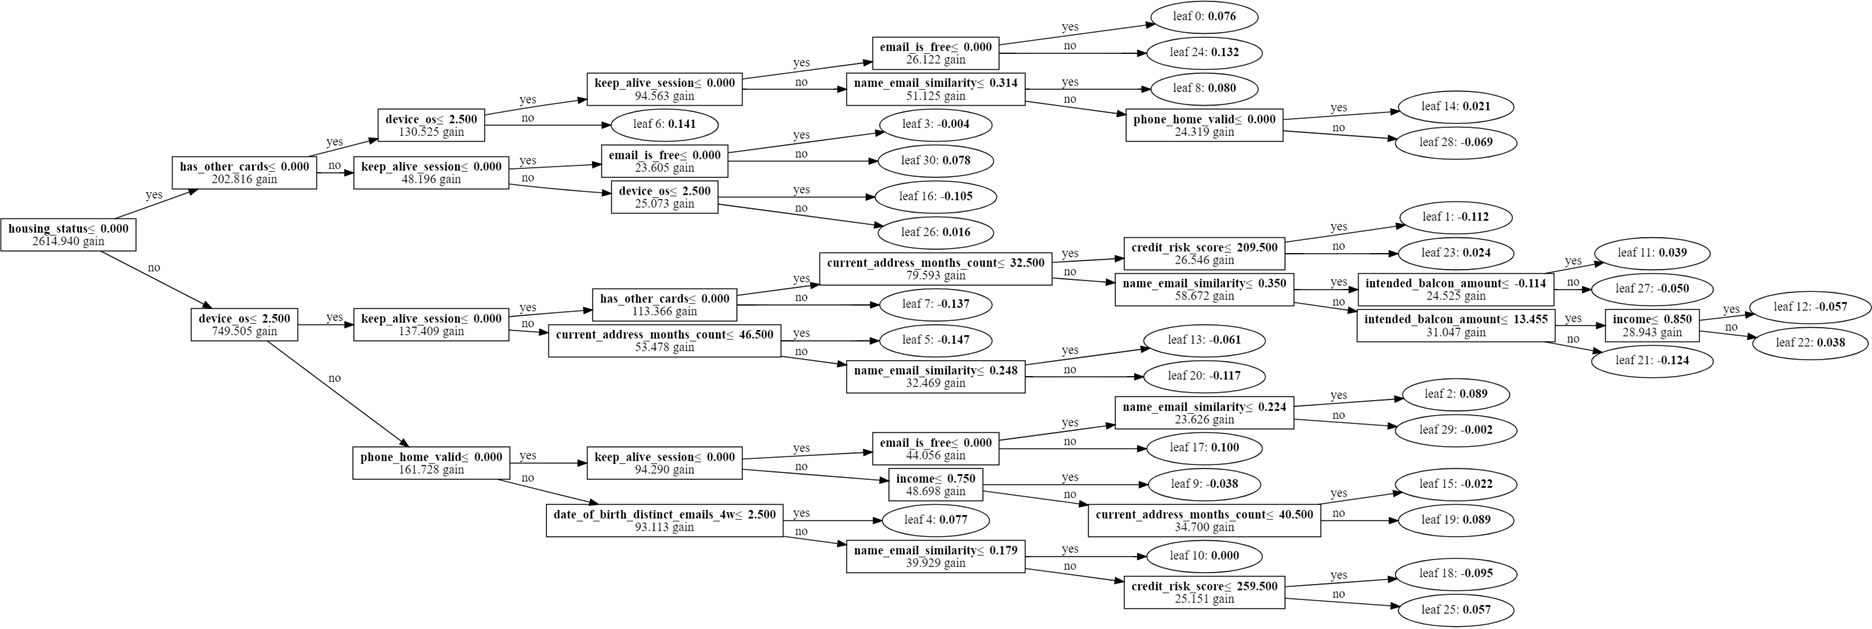

### Importancia de variables

Estaremos visualizando la importancia de las 12 variables más importantes para el modelo

Plotting feature importances...


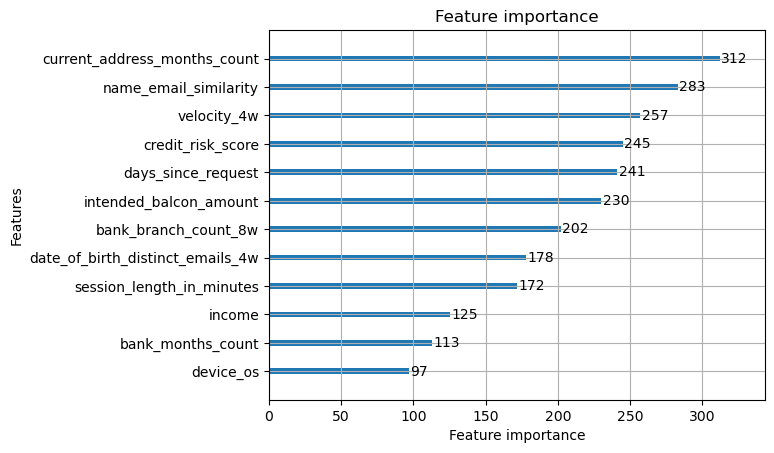

In [23]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(modelo, max_num_features=12)
plt.show()

Estas 12 variables son las que presentan mayor poder predictivo en nuestro modelo. De cara a desarrollo contínuo del modelo, analizar la importancia de las variables puede ayudar a reducir la dimensionalidad del dataset removiendo las variables de menor importancia para el modelo.

### Split Value Histogram

Construimos este histograma para observar cuál es el rango de valores más importante dentro de la toma de decisón del modelo para las variables housing_status, device_os, name_email_similarity, velocity_4w, current_address_months_count, y credit_risk_score. 
Cada  barra en el histograma corresponde a un rango de valores de división, y la altura de la barra indica cuántas divisiones ocurrieron dentro de ese rang. :

Si un valor de división en particular es frecuente, sugiere que el modelo encontró ese valor como informativo para tomar decisiones durante el proceso de construcción del árbol.

Split value histogram for current_address_months_count


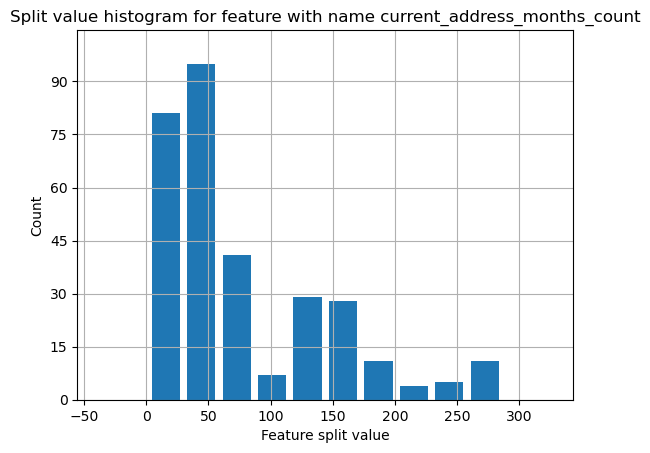

Split value histogram for name_email_similarity


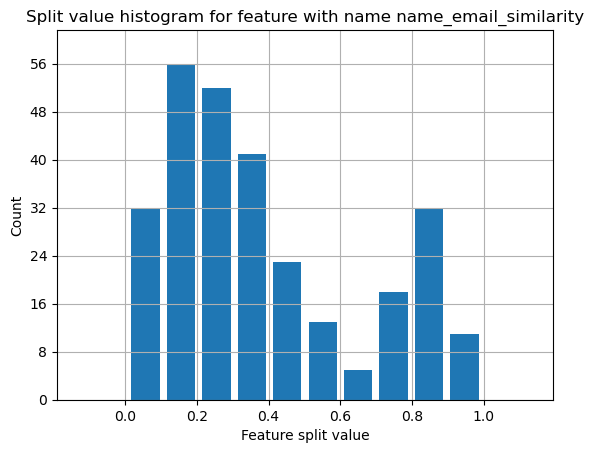

Split value histogram for velocity_4w


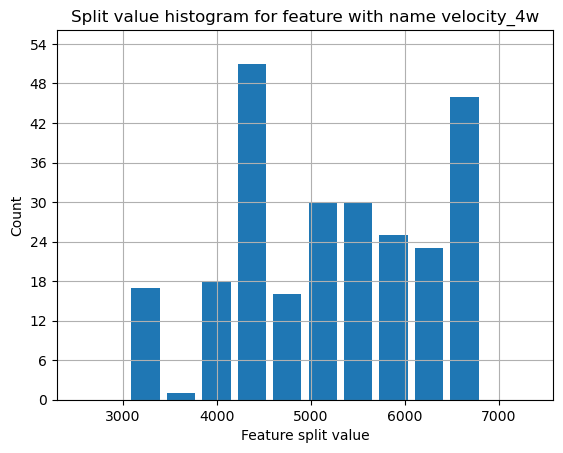

Split value histogram for credit_risk_score


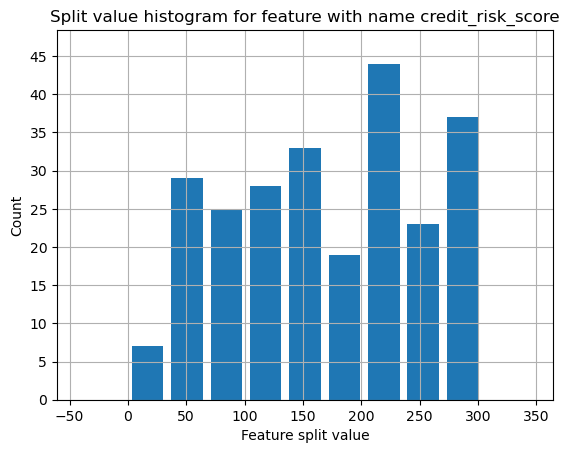

Split value histogram for intended_balcon_amount


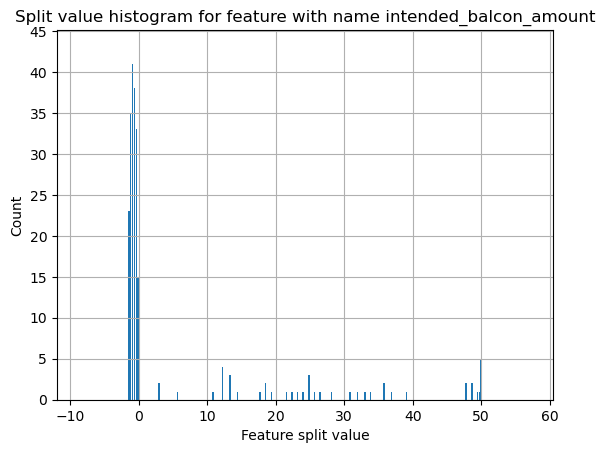

Split value histogram for housing_status


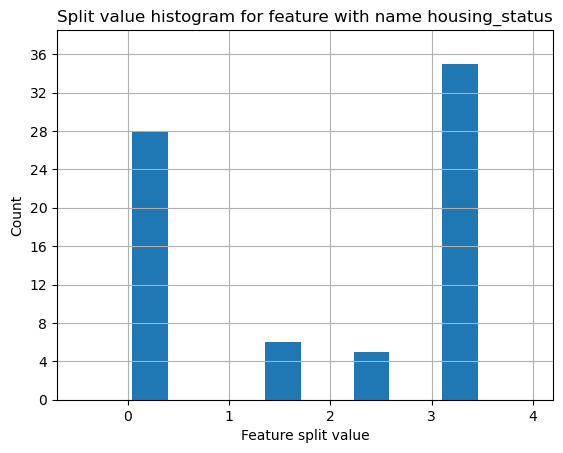

Split value histogram for device_os


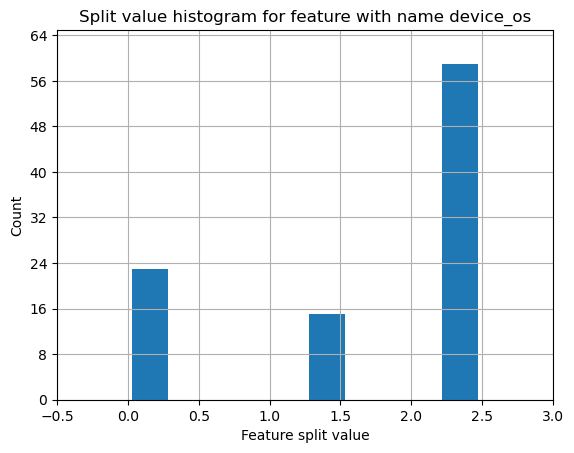

In [27]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import Booster

def split_value_histogram(model, variables, bins='auto'):
    if not isinstance(model, (Booster, lgb.LGBMModel)):
        raise TypeError('Model must be Booster or LGBMModel.')

    for variable in variables:
        print(f'Split value histogram for {variable}')
        ax = lgb.plot_split_value_histogram(model, feature=variable, bins=bins)
        plt.show()

modelo = modelo  


variables = ['current_address_months_count','name_email_similarity','velocity_4w','credit_risk_score','intended_balcon_amount','housing_status', 'device_os']


split_value_histogram(modelo, variables)

1. Current_address_months_count: en esta visualización vemos que los dos splits más significativos para el árbol de decisión del modelo dentro de esta variable se encuentran en el rango del **[0 - 50]** por diferencia notable al resto del split. Esto sugiere que el resto de rangos no son de igual importancia para generar splits dentro del árbol de decisión ya que no aportan información importante para el modelo.
2. Name_email_similarity: dentro de esta variable notamos una distribución regular dentro de las barras que indican la frencuencia de splits dentro de cada rango de valor. Hay barras representando mayor frecuencia de split lo cual indica mayor nivel de información, pero no se observa una caída repentina entre las barras subsiguientes. Esto  nos lleva a concluir que aunque hayan valores más informativos que otros para generar el split los primeros 5 splits especialmente son grandemente informativos para el split generado en el árbol de decisión del modelo a partir de esta variable.
3. Velocity_4w: En esta varible vemos las aplicaciones por hora hechas en las últimas 4 semanas. En nuestro histograma vemos que los rangos más informativos para el split del árbol de decisión del modelo son entre **[4000 - 5000]** y **[6000 - 7000]**. El resto de valores dentro de la variable aportan menos a la importancia de esta variable para el modelo.  
4. Credit_risk_score: esta variable se compone de valores anonimizados, por tanto no conocemos exactamente qué informan los valores por motivos de protección de los clientes. Lo que podemos observar dentro del histograma es que los dos splits que más informan al árbol de decisión del modelo para esta variable se encuentran dentro de los rangos del **[200 - 250]** y del **[250 - 300]**.
5. Intended_balcon_amount: dentro de esta variable podemos encontrar que el split más informativo se encuentra dentro del rango del **[-1 - 0]**, estos valores representan los datos faltantes dentro de la variable. Esta visualización nos sugiere que es importante para el árbol de decisión del modelo ver los valores faltantes de esta variable en específico para generar el split y consecunetemente clasificar una instancia como fraudulenta o no.
6. Housing_status: para esta variable podemos observar en el histograma que el split más informativo de esta variable está en el rango del **[3 - 4]**. El segundo split más informativo se encuentra en el rango del **[0 - 1]** y el resto de barras son menores por una diferencia notable. La diferencia observada sugiere que para el modelo son cruciales solo los splits en el rango del [3 - 4] y del [0 - 1]. Los valores dentro de esta variable están anonimizados por motivos de protección de los clientes. 
7. Device_os: para el histograma de esta variable podemos ver que hay un split altamente significativo para el árbol de decisión dentro del rango del **[2 - 2.5]** esto indica que la importancia de esta variable para el modelo se concentra en este rango de valores específicamente. Dentro de estos valores están representadas las aplicaciones que originan de un dispositivo con sistema operativo no especificado, la información que conocemos sobre el sistema operativo es que no es macintosh, windows, linux ni x11. 

### Explicabilidad con SHAP 

Estaremos visualizando los gráficos del Tree Explainer con Summary Plot y el Summary Plot de la librería SHAP. Estos modelos proveen la importancia de las variables del modelo según su valor shapley.

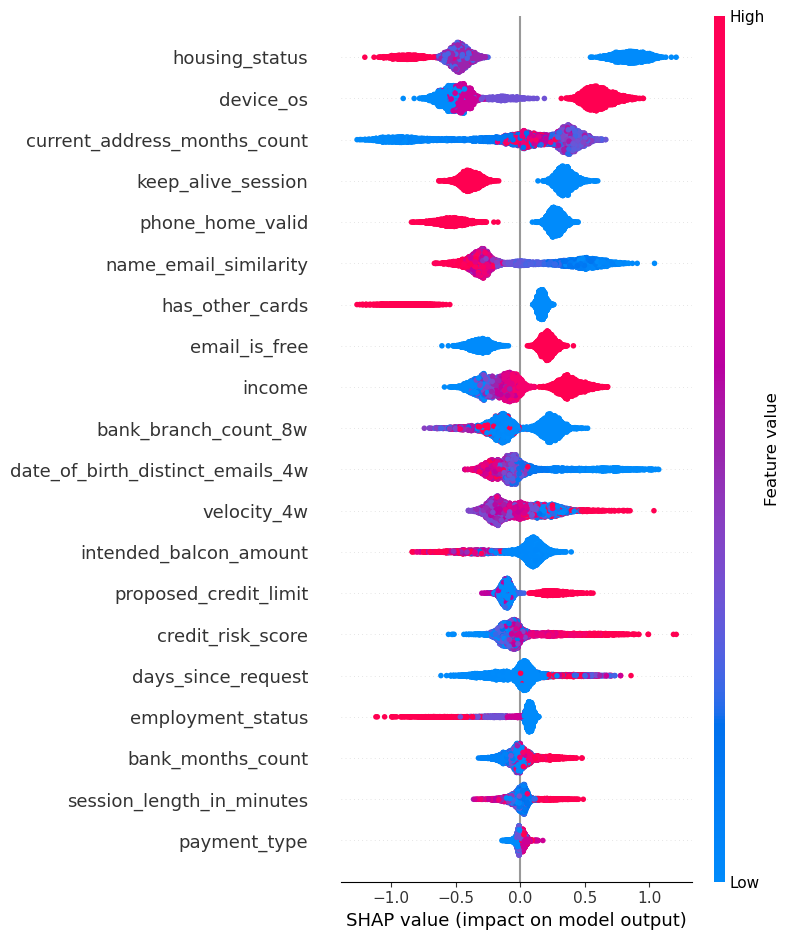

CPU times: total: 14.7 s
Wall time: 4.18 s


In [9]:
%%time
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X_test_red)
shap.summary_plot(shap_values[1], X_test_red)

Este gráfico ordena las variables por orden de importancia de arriba hacia abajo, estando arriba los valores más importantes. El eje horizontal nos informa de la magnitud predictiva de los valores SHAP. El gráfico de SHAP para nuestro modelo sugiere que un valor alto de housing_status indica menor riesgo de fraude, un valor alto de device_os conduce a una predicción de fraude y los valores bajos de current_address_months_count llevan a que se identifique una aplicación como no fraudulenta.

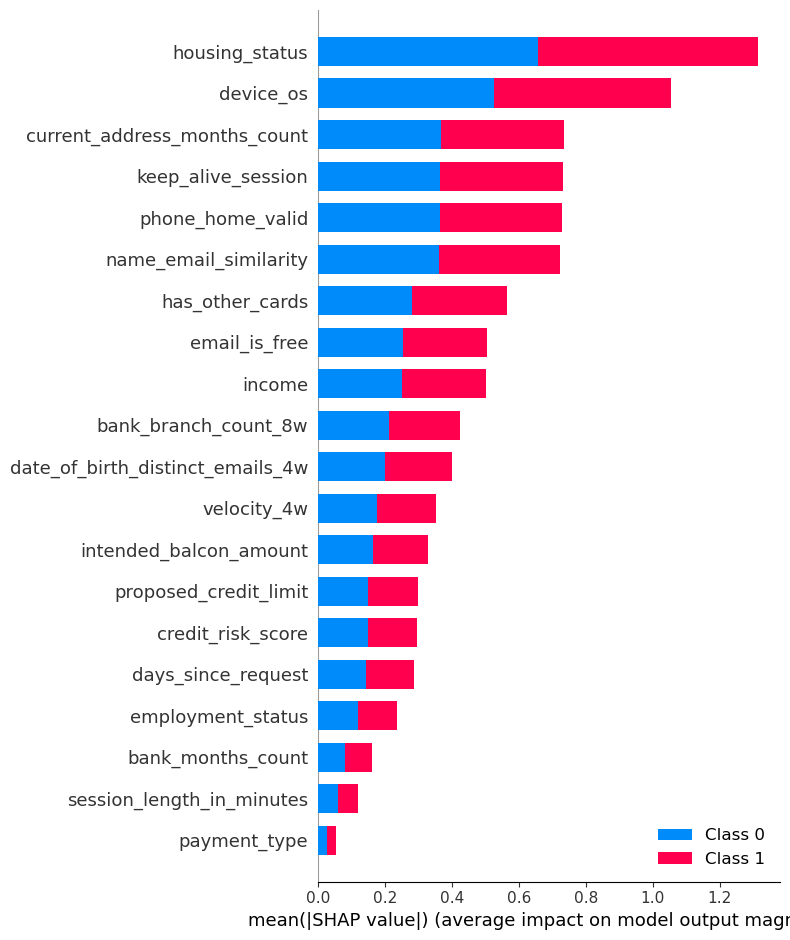

In [32]:
shap.summary_plot(shap_values, X_test_red)

En este gráfico podemos observar que las variables con mayor impacto en el modelo son housing_status, device_os, current_address_months_count, keep_alive_session, phone_home_valid y name_email_similarity. La distribución de instancias con fraude y sin fraude están balanceadas por el proceso de balanceado de datos con undersampling en el notebook 3. 

### Prevención de fraude

Estaremos creando perfiles de las aplicaciones fraudulentas para observar a fondo las características comunes y ayudarnos de esta información para evitar el fraude. Usaremos el Robust Scaler de la librería de scikit learn para mantener nuestros datos dentro de la primera y tercera percentila del rango intercuartil (IQR) y eliminar el ruido causado por los outliers en nuestros datos.

Filtraremos nuestro dataset para estudiar solo las instancias donde se comete fraude

In [11]:
test_data = test_data[test_data['fraud_bool'] == 1]

X_test_red = test_data.drop('fraud_bool', axis=1)
y_test_red = test_data['fraud_bool']

In [12]:
scaler = sklearn.preprocessing.RobustScaler()
model_scaled = scaler.fit(X_test_red)
X_scaled = pd.DataFrame(scaler.transform(X_test_red), columns=X_test_red.columns, index=X_test_red.index)

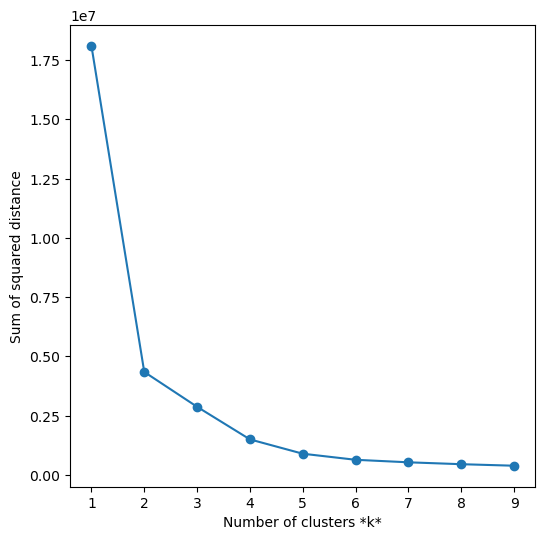

In [13]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Según observamos con el gráfico de codo, se obtuvieron 4 clusters a partir de nuestro conjunto de datos

In [14]:
k_clf = KMeans(n_clusters = 5, random_state = 0)
k_clf.fit(X_scaled)
pd_final_cluster = pd.DataFrame(k_clf.predict(X_scaled), index=X_scaled.index)
pd_final_cluster.columns = ['cluster']
pd_data = pd.concat([pd_final_cluster, test_data],axis=1)

In [15]:
pd_data['cluster'].value_counts()

cluster
0    1681
4     173
3     170
1      94
2      81
Name: count, dtype: int64

In [16]:
pd_data[pd_data['cluster']==1].describe()

,cluster,income,name_email_similarity,current_address_months_count,days_since_request,intended_balcon_amount,payment_type,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,...,email_is_free,housing_status,phone_home_valid,bank_months_count,has_other_cards,proposed_credit_limit,session_length_in_minutes,device_os,keep_alive_session,fraud_bool
count,94.0,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.0
mean,1.0,0.712766,0.367588,79.989362,6.655487,6.529587,1.329787,5050.191511,90.521277,8.053191,...,0.734043,1.010638,0.212766,9.680851,0.053191,527.553191,7.702557,2.202128,0.287234,1.0
std,0.0,0.256626,0.301147,66.899780,0.191354,15.272997,0.943436,876.958438,321.394767,4.908555,...,0.444211,1.231265,0.411458,12.698499,0.225618,527.101398,5.727944,1.131939,0.454898,0.0
min,1.0,0.100000,0.014113,3.000000,5.034122,-1.588011,0.000000,3079.238552,0.000000,1.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,200.000000,1.274129,0.000000,0.000000,1.0
25%,1.0,0.600000,0.119171,32.250000,6.682272,-1.197553,0.000000,4687.582554,0.000000,4.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,200.000000,3.567999,2.000000,0.000000,1.0
50%,1.0,0.900000,0.218292,58.000000,6.682272,-0.843229,2.000000,5177.358020,1.000000,7.500000,...,1.000000,0.000000,0.000000,1.000000,0.000000,200.000000,5.954179,3.000000,0.000000,1.0
75%,1.0,0.900000,0.687442,113.750000,6.682272,-0.163454,2.000000,5565.868929,9.750000,11.750000,...,1.000000,2.000000,0.000000,25.000000,0.000000,867.500000,9.544579,3.000000,1.000000,1.0
max,1.0,0.900000,0.996308,291.000000,6.682272,50.394003,3.000000,6787.813894,1463.000000,20.000000,...,1.000000,4.000000,1.000000,31.000000,1.000000,1500.000000,21.698864,3.000000,1.000000,1.0


#### Perfil del grupo
En este grupo se encuentran las personas con mayores ingresos dentro de la categoría de aplicaciones fraudulentas, llevan la menor cantidad de tiempo en su residencia actual y al momento de enviar su aplicación hubo la mayor cantidad de aplicaciones en 24 en un periodo de 4 semanas de los 4 perfiles. En este perfil lo habitual es que las personas cometiendo fraude cierren sus sesiones al terminar la aplicación y al igual que los otros perfiles la mayoría de los usuarios tienen el sistema operativo windows o x11 en los dispositivos que usaron para enviar su aplicación.


#### Medidas de prevención de fraude para este grupo
- Para prevenir el fraude de este grupo proponemos que se sometan a una revisión manual las aplicaciones que indiquen altos niveles de ingresos comparados con la media en periodos de 4 semanas donde se han registrado una alta cantidad de aplicaciones dentro de un periodo de 24 horas 

In [18]:
pd_data[pd_data['cluster']==2].describe()

,cluster,income,name_email_similarity,current_address_months_count,days_since_request,intended_balcon_amount,payment_type,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,...,email_is_free,housing_status,phone_home_valid,bank_months_count,has_other_cards,proposed_credit_limit,session_length_in_minutes,device_os,keep_alive_session,fraud_bool
count,81.0,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,...,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0
mean,2.0,0.623457,0.337175,94.732818,2.768724,0.393467,1.790123,4911.715814,49.160494,6.851939,...,0.654321,0.827160,0.197531,5.691358,0.037037,740.740741,7.988262,2.049383,0.197531,1.0
std,0.0,0.289945,0.272083,61.902220,0.812617,6.896456,0.626818,796.986502,243.665111,3.643075,...,0.478552,1.330321,0.400617,11.865540,0.190029,598.493479,6.235912,1.203134,0.400617,0.0
min,2.0,0.100000,0.010833,1.000000,1.413122,-1.588011,0.000000,3056.650178,0.000000,1.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,200.000000,1.274129,0.000000,0.000000,1.0
25%,2.0,0.400000,0.109528,50.000000,2.151561,-1.240787,2.000000,4359.335266,0.000000,4.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,200.000000,3.456948,1.000000,0.000000,1.0
50%,2.0,0.700000,0.243835,86.817583,2.761180,-1.027934,2.000000,4965.087882,1.000000,7.000000,...,1.000000,0.000000,0.000000,-1.000000,0.000000,500.000000,5.883441,3.000000,0.000000,1.0
75%,2.0,0.900000,0.489695,117.000000,3.320038,-0.734265,2.000000,5417.683308,2.000000,9.000000,...,1.000000,2.000000,0.000000,9.000000,0.000000,1500.000000,10.280279,3.000000,0.000000,1.0
max,2.0,0.900000,0.996510,280.000000,4.529675,47.283960,3.000000,6816.976531,1463.000000,17.000000,...,1.000000,4.000000,1.000000,31.000000,1.000000,1500.000000,21.698864,3.000000,1.000000,1.0


#### Perfil del grupo
En este grupo se encuentran las personas con direcciones de correo electrónico menos similares a sus nombres dentro de la categoría de aplicaciones fraudulentas y promedian 94 meses en su residencia actual. Los números telefónicos provistos como parte de estas aplicaciones no tienden a ser válidos según indicado por la variable phone_home_valid. En este perfil lo habitual es que las personas cometiendo fraude cierren sus sesiones al terminar la aplicación y al igual que los otros perfiles la mayoría de los usuarios tienen el sistema operativo windows o x11 en los dispositivos que usaron para enviar su aplicación.


#### Medidas de prevención de fraude para este grupo
- Para prevenir el fraude de este grupo proponemos que se sometan a una revisión manual las aplicaciones con correos electrónicos que no se asemejan a los nombres de las personas en su aplicación y que tengan números telefónicos residenciales que no sean válidos. Entendemos que es importante esta capa adicional de revisión porque puede ser indicativo de que todos los datos de la aplicación fueron generados al azar.

In [19]:
pd_data[pd_data['cluster']==3].describe()

,cluster,income,name_email_similarity,current_address_months_count,days_since_request,intended_balcon_amount,payment_type,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,...,email_is_free,housing_status,phone_home_valid,bank_months_count,has_other_cards,proposed_credit_limit,session_length_in_minutes,device_os,keep_alive_session,fraud_bool
count,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0
mean,3.0,0.648824,0.399416,114.481797,0.061300,5.604260,1.217647,5025.298799,1241.270588,6.891239,...,0.582353,0.894118,0.352941,16.235294,0.088235,858.117647,7.476457,2.282353,0.376471,1.0
std,0.0,0.292153,0.298146,69.418073,0.256739,15.445502,0.926107,951.513763,313.143005,4.743599,...,0.494628,1.130780,0.479296,12.536477,0.284475,599.348747,5.822124,1.110592,0.485932,0.0
min,3.0,0.100000,0.024181,3.000000,0.001423,-1.588011,0.000000,3009.832093,643.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,200.000000,1.274129,0.000000,0.000000,1.0
25%,3.0,0.500000,0.128700,56.250000,0.005479,-1.071500,1.000000,4287.123876,843.750000,3.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,200.000000,3.696316,2.000000,0.000000,1.0
50%,3.0,0.800000,0.349757,98.000000,0.014111,-0.761061,1.000000,5099.330047,1463.000000,6.000000,...,1.000000,0.000000,0.000000,20.000000,0.000000,1000.000000,5.140795,3.000000,0.000000,1.0
75%,3.0,0.900000,0.642557,164.000000,0.022495,-0.377579,1.000000,5610.819099,1463.000000,9.000000,...,1.000000,2.000000,1.000000,28.000000,0.000000,1500.000000,9.234467,3.000000,1.000000,1.0
max,3.0,0.900000,0.996462,286.000000,1.841378,50.394003,3.000000,6889.977775,1463.000000,23.000000,...,1.000000,4.000000,1.000000,31.000000,1.000000,1500.000000,21.698864,3.000000,1.000000,1.0


#### Perfil del grupo
En este grupo podemos ver en la variable bank_branch_count que las personas en este grupo hicieron sus aplicaciones de crédito en bancos donde se someten un alto volumen de aplicaciones y solicitaron la mayor cantidad de crédito entre los clusters. En este perfil lo habitual es que las personas mantengan sus sesiones abiertas al terminar la aplicación y al igual que los otros perfiles la mayoría de los usuarios tienen el sistema operativo windows o x11 en los dispositivos que usaron para enviar su aplicación.


#### Medidas de prevención de fraude para este grupo
- Para prevenir el fraude de este grupo proponemos que se inspeccionen las sucursales bancarias en dónde se somete un alto volumen de aplicaciones de crédito para asegurarse de que siguen el protocolo establecido y que estén tengan las pruebas que el banco entienda necesarias para comprobar la información que se provea en la aplicación. 

In [20]:
pd_data[pd_data['cluster']==4].describe()

,cluster,income,name_email_similarity,current_address_months_count,days_since_request,intended_balcon_amount,payment_type,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,...,email_is_free,housing_status,phone_home_valid,bank_months_count,has_other_cards,proposed_credit_limit,session_length_in_minutes,device_os,keep_alive_session,fraud_bool
count,173.0,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,...,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.0
mean,4.0,0.693642,0.448909,115.147634,0.045585,40.997353,0.138728,4987.475523,47.589595,7.453778,...,0.601156,0.976879,0.306358,15.566474,0.150289,771.791908,7.364461,2.173410,0.341040,1.0
std,0.0,0.250383,0.314902,68.728621,0.182334,11.029588,0.509620,1043.390320,150.168740,4.529390,...,0.491082,1.311637,0.462319,11.207993,0.358392,549.421178,5.752295,1.091185,0.475435,0.0
min,4.0,0.100000,0.000444,1.000000,0.001423,20.215492,0.000000,3047.349696,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,200.000000,1.274129,0.000000,0.000000,1.0
25%,4.0,0.600000,0.126625,64.000000,0.004767,30.329641,0.000000,4246.779155,1.000000,4.000000,...,0.000000,0.000000,0.000000,4.000000,0.000000,200.000000,3.634660,2.000000,0.000000,1.0
50%,4.0,0.800000,0.443539,100.000000,0.010714,48.534105,0.000000,5020.191578,3.000000,7.000000,...,1.000000,0.000000,0.000000,15.000000,0.000000,500.000000,5.426828,3.000000,0.000000,1.0
75%,4.0,0.900000,0.752925,169.000000,0.019758,50.394003,0.000000,5901.814371,15.000000,11.000000,...,1.000000,2.000000,1.000000,25.000000,0.000000,1500.000000,8.975123,3.000000,1.000000,1.0
max,4.0,0.900000,0.999858,290.000000,1.417783,50.394003,3.000000,6849.305750,885.000000,21.000000,...,1.000000,4.000000,1.000000,31.000000,1.000000,1500.000000,21.698864,3.000000,1.000000,1.0


#### Perfil del grupo
En este grupo se encuentran las personas que más tiempo llevan en su residencia actual, con las direcciones de correo electrónico que más se asemejan al nombre incluído en la aplicación y que enviaron la mayor cantidad de dinero como parte de su aplicación. En este perfil lo habitual es que las personas mantengan sus sesiones abiertas al terminar la aplicación. Al igual que los otros perfiles, la mayoría de los usuarios tienen el sistema operativo windows o x11 en los dispositivos que usaron para enviar su aplicación y no tienen otras tarjetas de crédito. Este perfil tiene las cualidades que más aparentan pertenecer a aplicaciones legítimas entre los grupos observados.  


#### Medidas de prevención de fraude para este grupo
- Para prevenir el fraude de este grupo proponemos que se inspeccionen las aplicaciones que se completan en una sesión de menos de 8 minutos que representa la media habitual del dataset según observado en los clusters del tercer notebook, ya que puede ser indicativo de que la persona no esta completando la aplicación de una manera cuidadosa y está imitando los valores que pudieran pertenecer a una aplicación legítima. 

### Conclusiones

En conclusión, este notebook se centró en explorar la explicabilidad de un modelo de detección de fraude construido con LightGBM, utilizando diversas herramientas como árboles de decisión, gráficos de importancia de variables, histogramas de valores de división y SHAP (SHapley Additive exPlanations). Estas herramientas proporcionan una visión más completa y transparente del modelo, permitiendo una toma de decisiones más informada en aplicaciones críticas.

Los resultados revelaron que ciertas variables, como `housing_status`, `device_os`, `current_address_months_count`, entre otras, desempeñan roles significativos en las predicciones del modelo. Además, se emplearon técnicas de clustering para crear perfiles de instancias fraudulentas, proporcionando información valiosa para la prevención del fraude en diferentes grupos.

Las sugerencias de medidas de prevención de fraude para cada cluster, basadas en perfiles específicos, ofrecen orientación práctica para la identificación y mitigación de actividades fraudulentas. La combinación de interpretaciones visuales y perfiles detallados contribuye a una comprensión más profunda y operativa del modelo de detección de fraude. En conjunto, este enfoque proporciona una herramienta valiosa para mejorar la eficacia y la eficiencia de las estrategias antifraude en entornos financieros y de seguridad.